## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from model_classes import HealthModel
import torch
from datetime import datetime as dt

## Config

Linear regressor config:

In [2]:
config = {
    "architecture": "linear_regressor",
    "train_size": 0.8,
    "val_size": False, # Set MLP 
    "hidden_layer_sizes": False, # configs
    "batch_size": False, # to False
    "num_epochs": False, # if using
    "learning_rate": False, # linear regressor
    "species": "NO2",
    "spatial_resolution": "regional",
    "temporal_resolution": "daily",
    "input_artifacts": ["laqn-regional", "met-resample", "income-regional"],
    "met_variables": ["temperature"], # Set to False if excluding meteorology
    "target_shift": 0 # Time lag for target variable
    }

plot_title_model = f"(all inputs, time lag {config['target_shift']})"

MLP regressor config:

In [2]:
config = {
    "architecture": "MLP_regressor",
    "train_size": 0.7,
    "val_size": 0.15, # Set MLP configs
    "hidden_layer_sizes": [10],
    "batch_size": 30, # to False
    "num_epochs": 100, # if using
    "learning_rate": 0.001, # linear regressor
    "species": "NO2",
    "spatial_resolution": "regional",
    "temporal_resolution": "daily",
    "input_artifacts": ["laqn-regional", "met-resample", "income-regional"],
    "met_variables": ["temperature"], # Set to False if excluding meteorology
    "target_shift": 0 # Time lag for target variable
    }

plot_title_model = f"(all inputs, time lag {config['target_shift']})"
torch.manual_seed(1)

## Code

In [3]:
model = HealthModel(config)

In [4]:
df = model.preprocess_and_log()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michellewl. Use `wandb login --relogin` to force relogin


laqn-regional


wandb:   3 of 3 files downloaded.  


(8401,)
(8401,)
(8401,)
met-resample


wandb:   8 of 8 files downloaded.  


income-regional


wandb:   1 of 1 files downloaded.  


Index(['NO2_mean', 'NO2_min', 'NO2_max', 'temperature_mean', 'temperature_min',
       'temperature_max', 'income'],
      dtype='object')


wandb:   1 of 1 files downloaded.  


In [21]:
df.columns

Index(['NO2_mean', 'NO2_min', 'NO2_max', 'temperature_mean', 'temperature_min',
       'temperature_max', 'income', 'deaths'],
      dtype='object')

<AxesSubplot:>

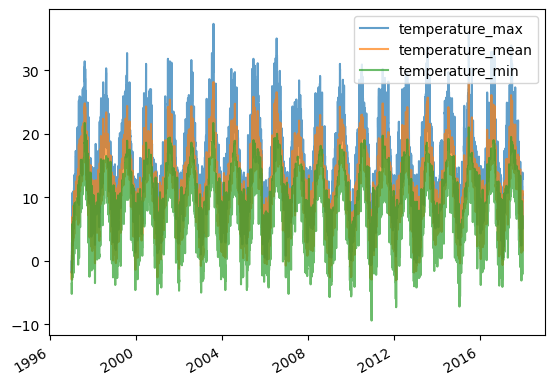

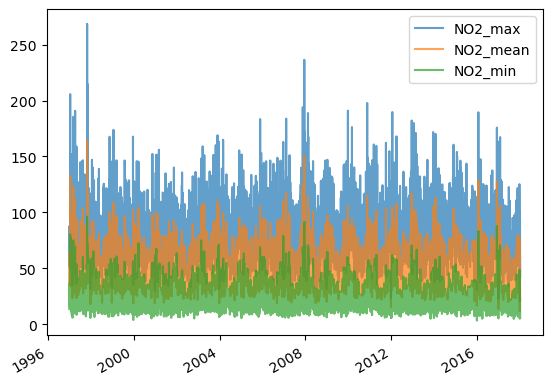

In [22]:
df[["temperature_max", "temperature_mean", "temperature_min"]].plot(alpha=0.7)

df[["NO2_max", "NO2_mean", "NO2_min"]].plot(alpha=0.7)

In [23]:
print(f"Time lag: {config['target_shift']}")
model.create_baseline()

0


wandb:   1 of 1 files downloaded.  


baseline_mean_absolute_percentage_error,▁
baseline_mean_squared_error,▁
baseline_r_squared,▁
baseline_root_mean_squared_error,▁
baseline_symmetric_mean_absolute_percentage_error,▁
baseline_mean_absolute_percentage_error,0.0
baseline_mean_squared_error,0.0
baseline_r_squared,1.0
baseline_root_mean_squared_error,0.0
baseline_symmetric_mean_absolute_percentage_error,0.0


In [5]:
model.train_and_log()

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


best_epoch,▁
best_mean_absolute_percentage_error_train,▁
best_mean_absolute_percentage_error_val,▁
best_mean_squared_error_train,▁
best_mean_squared_error_val,▁
best_r_squared_train,▁
best_r_squared_val,▁
best_rmse_train,▁
best_rmse_val,▁
best_smape_train,▁
best_smape_val,▁


In [6]:
data_dict = model.test_and_log()

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


mean_absolute_percentage_error_test,▁
mean_squared_error_test,▁
r2_test,▁
rmse_test,▁
smape_test,▁
mean_absolute_percentage_error_test,9.68426
mean_squared_error_test,0.04539
r2_test,0.20999
rmse_test,0.21304
smape_test,10.17131


#### Alternative
If the model has already been run, lookup the test_and_log output artifact version on the wandb web interface and read it in here:

In [52]:
#data_dict = model.read_data("xy_all", "v2") 

## Plot results

In [8]:
df = pd.DataFrame()
subsets = ["train", "val", "test"] if config["val_size"] else ["train", "test"]
for subset in subsets:
    subset_df = pd.DataFrame(index=pd.DatetimeIndex(data_dict[f"{subset}_dates"]), data={"observed":data_dict[f"y_{subset}"], "predicted":data_dict[f"y_{subset}_predict"]})
    df = subset_df.copy() if df.empty else df.append(subset_df)

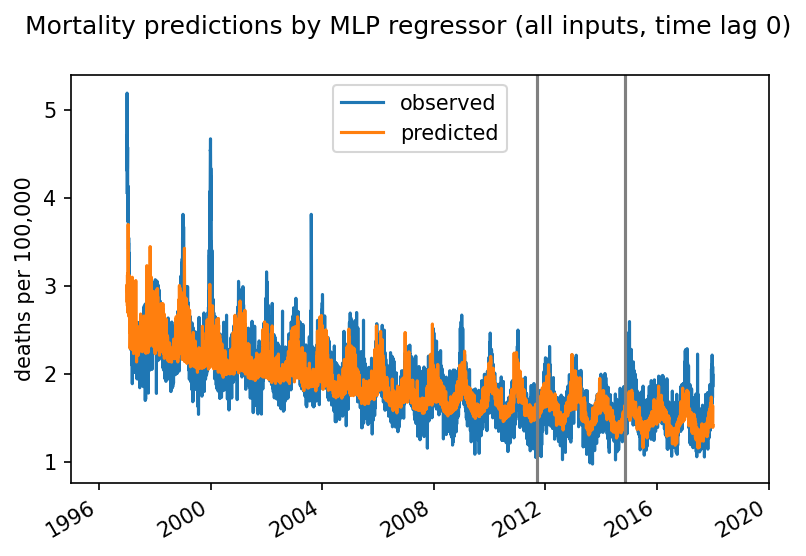

In [9]:
plt.figure(figsize=(6,4), dpi=150)
df["observed"].plot()
df["predicted"].plot()
plt.axvline(data_dict["train_dates"].max(), color="grey")
plt.axvline(data_dict["val_dates"].max(), color="grey") if config["val_size"] else None
plt.legend()
plt.ylabel("deaths per 100,000")
plt.xlim(dt(year=1995, month=1, day=1), dt(year=2020, month=1, day=1))
regressor_title = config["architecture"].replace("_", " ")
plt.suptitle(f"Mortality predictions by {regressor_title} {plot_title_model}")
plt.show()